# Predicting The Phases of a 2-D Ising Model using Machine Learning 

## Section 1: Generation of 2-D Ising Dataset

### Basic idea of paramagnetism and ferromagnetism 

In ideal paramagnetism, each magnetic dipole only responds to the external magnetic field (if any): the dipoles have no inherent tendency to point parallel (or anti-parallel) to their neighbours. However, in reality, the dipoles are influenced by their neighbours. Each dipole can either be aligned parallel or anti-parallel to their neighbours due to quantum-mechanical effects. Depending on the relative alignment of neighbouring dipoles, there is a gain or loss in the energy of the system. 

Ferromagnetism refers to the phenomenon where neighbouring dipoles align parallel to one another even in the absence of an external magnetic field. A classical example of a material that exhibits ferromagnetism is iron. The strong alignment of dipoles in a ferromagnet, such as iron, manifests itself as a net non-zero magnetisation. Raising the temperature, however, causes random thermal flunctuations that decrease the overall magnetisation. For every ferromagnet, there is a certain critical temperature (known as the Curie temperature) at which net magnetisation becomes zero (when there is no external magnetic field). Above the Curie temperature, the ferromagnet turns into a paramagnet. 

Even if the temperature is below the Curie temperature, a ferromagnet (e.g. iron) might not be magnetised. This is because of the presence of magnetic domains. These are microscopic clusters of dipoles. Within each cluster, the dipoles are aligned parallel to one another, but the alignment of dipoles in one domain gives neighbouring domains the tendencies to align in the opposite direction. Since there are so many domains, with about as many pointing one way or another, the overall net magnetisation is zero.

However, placing a ferromagnetic material in the presence of a strong external magnetic field may overcome the interaction between domains and cause all dipoles to align parallel to the field. Upon removing the external magnetic field, the interaction between dipoles prevent any significant realignment, eventually creating a permanent magnet. 

### Modelling ferromagnetism with the 2-D Ising model

The 2-D Ising model can be easily visualised as a set of elementary magnetic dipoles on a square lattice of points, with each dipole placed at each point. 

To simplify any complexities, interaction between nearest neighbouring dipoles are only considered in the model and any long-range interactions are neglected. Also, the model further assumes that the ferromagnet only has one preferred axis of magnetisation and that each atomic dipole can only point parallel or anti-parallel to this axis. 

Note: The Ising model is by far not an accurate representation of a real-life ferromgnet. Even if there is only a preferred axis of magnetisation and the dipoles can only align in two possible directions along this axis, reality is much more subtle than this and this can be only be addressed in more advanced courses of solid-state physics. The Ising model does not yield accurate predictions for the low temperature behaviour of a ferromagnet. However, it does yield accurate predictions near the Curie temperature. 

### Monte Carlo methods in generating the dataset

A variant of Monte Carlo methods will be used to generate the dataset for this project. Considering just a medium-sized (100 or so elementary dipoles) 2-D Ising model on a square lattice, even the fastest computer could not have compute the probabilities of all the possible states (or configurations) of the system. However, it may be sufficent enough to consider just a random sampling of states instead of all the possible states and use this sample to estimate the average energy, magnetisation and other quantities. This is the basic idea behind Monte Carlo simulation.

However, there is a catch, specifically for the case of the Ising model. Even if we consider a random sampling of - say, a billion states, this is only a "tiny" fraction - one in $10^{21}$ - of all the possible states, even for a small 10 x 10 square lattice. At temperatures lower than the Curie temperature, when the system "wants" to magnetise, the "relevant" states (states with majority of the dipoles pointing in one direction or the other) only makes up a "small" fraction of all the possible states such that random sampling will miss them completely. The states that a single dipole can be in (either aligning parallel or anti-parallel) are not all equally probable especially with each dipole interacting with its neighbours. Depending on each dipole's energy contribution to the system, some states are much more pobable than others; simply sampling at random alone the states is just not sufficient.

Instead, a better idea will be to use the Boltzmann factor to guide the random generation of states to sample. The boltzmann factor is an important mathematical tool in statistical mechanics that relates to the probability of finding a system in any particular state, when that system is in thermal equilibrium with a "reservoir" at a specified temperature. The probability of finding the system at a particular state $s$ is given by 

$$ P(s) \propto e^{\frac{-E(s)}{k_{b}T}}$$

where $k_{b}$ is the Boltzmann constant, $E(s)$ is the energy of the system being in state $s$ and $T$ is the temperature of the "reservoir".

A specific Monte Carlo method using the Boltzmann factor as a guidance is as follows:

1) Randomly initialise a state of the system.

2) Randomly choose a dipole and consider the probability of "flipping" it to the other state (i.e. parallel to anti-parallel or vice versa)

3) Compute its contribution (gain or loss), $\Delta U$, to the energy of the entire system as a result of "flipping" the dipole.

4) If $\Delta U \le 0$, the system's energy would decrease or remained unchanged. Go ahead and "flip" the dipole to consider the new system's state.

5) If $\Delta U > 0$, the system's energy would increase. Decide at random whether to "flip" this dipole, with the probability of "flipping" it being $e^{\frac{-\Delta U}{k_{b}T}}$. If the dipole does not get "flipped", then the new system state will be exactly similar to the previous one.

6) Repeat Steps 1 to 5 by randomly choosing another dipole, until every dipole has had many chances to be "flipped".

The algorithm described above is known as the Metropolis algorithm, a variant of Monte Carlo method that placed an emphasis on importance sampling. It was first introduced by Nicholas Metropolis in 1953. The Metropolis algorithm ensures that low-energy states occur more frequently than high-energy states. 

In practice, the algorithm will only be run for a relatively small number of iterations, so most states will never be generated at all. Under these circumstances, there is no guarantee that the sample of states generated will "accurately" represent the full collection of all the possible states. Nevertheless, the main concern will be that the randomly generated sample of states will give an accurate picture of the expected energy and magnetisation of the system at specified temperatures. 

We begin by first importing the relevant Python libraries.

In [2]:
# Importing the relevant libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors
%matplotlib inline

### Part 1: Defining helper functions

Here, we define a few miscellaneous Python functions to help with our simulation.

In [3]:
# Define a function to initialise a square grid of a fixed size, n
# with elements randomly taking either the value of 1 (dipoles that are parallel) or -1 (dipoles that are anti-parallel)
def initialise_square_grid(n):
    '''
    Inputs: 
    - n = size of the 2D square array, an integer
    
    Output: Returns a (n x n) square array with elements randomly taking 1 or -1
    '''
    grid = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if np.random.rand(1) < 0.5:
                grid[i, j] = 1
            else:
                grid[i, j] = -1
    return grid



# Define a function to plot and colour-code a square grid (with title) to mimic a state
# Elements of value 1 should be coloured black (parallel dipoles)
# Elements of value -1 should be coloured white (anti-parallel dipoles)
def plot_grid(square_grid, title):
    '''
    Inputs: 
    - square_grid: (n x n) square array of elements 1 or -1
    - title: Title as a string
    
    Output: Colour code the square array: value 1 will be coloured black; value -1 will be coloured white
    '''
    cmap = colors.ListedColormap(['white', 'black'])
    norm = colors.BoundaryNorm([-2,0,2], cmap.N)
    
    # Plotting and colour coding
    fig, axes = plt.subplots()
    axes.imshow(square_grid, cmap = cmap, norm = norm)
    axes.set_title(title)
    axes.set_xticks([])
    axes.set_yticks([])


    
# Define a function to compute the magnetisation in arbitrary units of a square grid 
# Essentially summing all the values of the elements in a grid
def magnetisation(square_grid):
    '''
    Inputs: 
    - square_grid: (n x n) square array of elements 1 or -1
    
    Output: Returns the sum of a square array based on the values of the elements (1 or -1)
    '''
    return np.sum(square_grid)

The following detail some considerations that are used to compute $\Delta U$.

### Energy of a 2-D Ising system

For a 2-D Ising model, the total energy of the system is given by 

$$ U = - \epsilon \sum_{i} \sum_{j} s_{i}s_{j} $$

where $\epsilon$ is a unit of interaction energy between a pair of dipoles (in arbitrary units) and $s_{i}$ is the current state of the ith dipole. The summation runs through all neighbouring pairs of $i$ and $j$.

By convention, $s_{i} = 1$ for parallel dipoles and $s_{i} = -1$ for anti-parallel dipoles.

### Periodic boundary conditions

Since the simulation uses a "relatively" small square lattice size, there is the problem of "edge effects". In the 2-D Ising model, dipoles at the edge of the lattice are less constrained to align with their neighbours than other dipoles elsewhere. In we are modelling a small system, we should treat the edges as edges, with fewer neighbours per dipole. 

However, we are interested in large systems, so we should at best try to minimise these "edge effects". One way to do so is to have the square lattice "wrap around", treating right edge as if it were immediately left of the left edge and the bottom edge as if it were immediately above the top edge. Such conditions are known as periodic boundary conditions.

With these considerations in mind, the following code define the Python functions that are crucial for the implementation of the Metropolis algorithm.

In [5]:
# Define a function to compute the change in interaction energy of the system as a result of flipping a dipole
# Units of epsilon, the energy between a pair of interacting spins
# i.e. Changing an element value from 1 to -1 (flipping a dipole from parallel to anti-parallel) or vice versa
# Change in interaction energy is computed using nearest-neighbours assumption 
# i.e. Change in interaction energy between the dipole that is flipped and its nearest four neighbours
# Minimising edge effects by using periodic boundary conditions:
# - Making the 2D lattice 'wrap' around
# - Treating the right edge as if it were immediately left of the left edge
# - Treating the bottom edge as if it were immediately above the top edge
def energy_change(square_grid, i, j):
    '''
    Inputs: 
    - square_grid: (n x n) square array of elements 1 or -1
    - i, j: (ij)-th element of the square grid, integers
    
    Output: Returns the change in 'interaction energy' as a result of changing the (ij)-th element 
    from 1 to -1 (or vice versa)
    '''
    n = square_grid.shape[0]
    # Treating edge effect at the top of the square array
    if (i == 0):
        top = square_grid[n-1, j]
    else:
        top = square_grid[i-1, j]     
    # Treating edge effect at the bottom of the square array
    if (i == n-1):
        bottom = square_grid[0, j]
    else:
        bottom = square_grid[i+1, j]
    # Treating edge effect on the left of the square array
    if (j == 0):
        left = square_grid[i, n-1]
    else:
        left = square_grid[i, j-1]
    # Treating edge effect on the right of the square array
    if (j == n-1):
        right = square_grid[i, 0]
    else:
        right = square_grid[i, j+1]
    
    # Compute the 'interaction energy' of the system as a result of changing an element from 1 to -1 (or vice versa)
    delta_U = 2 * square_grid[i,j] * (top + bottom + left + right)
    
    return delta_U
    


# Define a function that implements the Metropolis algorithm
def ising_simulation(n, T, plot = True):
    '''
    2D Ising simulation using Metropolis algorithm
    Inputs: 
    - n: size of the 2D square array, an integer
    - T: Temperature, in units of epsilon/boltzmann constant
    - plot: Decide if the square array is plotted at the beginning and the end of the simulation
    
    Output: Returns a possible square array with a probability proportional to the Boltzmann factor
    '''
    grid = initialise_square_grid(n)
    
    if plot == True:
        plot_grid(grid, title = 'Randomly initialised microstate')
    
    # Executes the Metropolis algorithm 100 times per element in a square array
    for iteration in range(100*n**2):
        # Randomly select an (ij)th-element of the square array
        ith_row = int(np.random.rand(1)*n)
        jth_col = int(np.random.rand(1)*n)
        
        # Compute the energy change of the system as a result of changing the value of (ij)th-element
        # from 1 to -1 (or vice versa)
        delta_E = energy_change(grid, ith_row, jth_col)
        
        # Change the value of (ij)th-element if delta_E <= 0
        # Else, decide at random whether to change the value, with a probability of the change being np.exp(-delta_U/T)
        # Boltzmann factor
        if delta_E <= 0:
            grid[ith_row, jth_col] = -grid[ith_row, jth_col]
        else:
            if np.random.rand(1) < np.exp(-delta_E/T):
                grid[ith_row, jth_col] = -grid[ith_row, jth_col]
        
    if plot == True:
        plot_grid(grid, title = 'Finalised possible microstate at T = %1.1f' %T)
    
    return grid

### Part 2: Generating a possible state at T = 10.0 (in units of $\epsilon / k_{B}$)

Here, the code for the Metropolis algorithm is tested with a 50 x 50 square array. The algorithm outputs one $\textbf{possible}$ state at temperature $T = 10.0$ given a randomly initialised state. Note that there are other possible states with this temperature and this is just one possible state. 

Nonetheless, it gives a good picture of what the system looks like at high temperatures (i.e. dipoles are randomly aligned).

array([[-1.,  1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -1., -1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1., -1., ...,  1.,  1., -1.],
       [ 1., -1.,  1., ...,  1.,  1.,  1.],
       [-1., -1.,  1., ...,  1., -1.,  1.]])

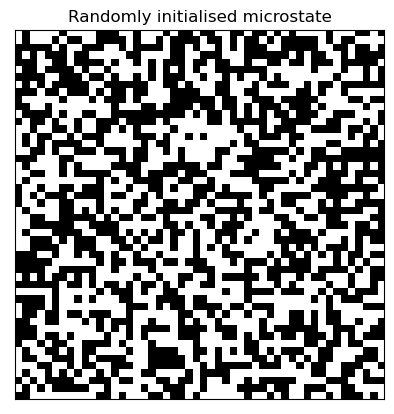

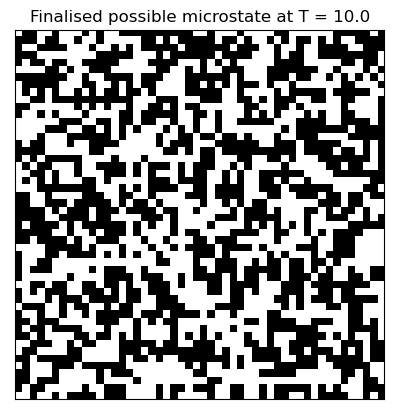

In [11]:
ising_simulation(50, 10, plot = True)

### Part 3: Generating typical states at various temperatures (in units of $\epsilon/k_{B}$)

Here, we use the Metropolis algorithm to generate typical states for a range of temperatures.

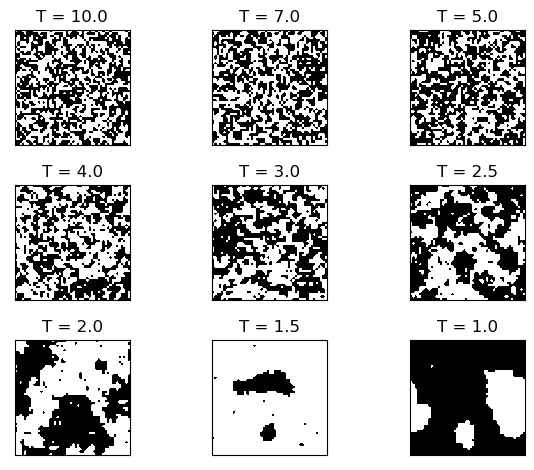

In [27]:
### Generation of 2D-Ising microstates at various temperatures

## Test: Generating typical microstates (50 x 50) at various temperatures
# T = 10.0, 7.0, 5.0, 4.0, 3.0, 2.5, 2.0, 1.5, 1.0

Temp = [10, 7, 5, 4, 3, 2.5, 2, 1.5, 1]
index = 0

fig, axes = plt.subplots(nrows=3, ncols=3)
axes = axes.reshape(9,)

for ax in axes:
    grid = ising_simulation(50, Temp[index], plot = False)
    
    cmap = colors.ListedColormap(['white', 'black'])
    norm = colors.BoundaryNorm([-2,0,2], cmap.N)
    
    ax.imshow(grid, cmap = cmap, norm = norm)
    ax.set_title('T = %1.1f' %Temp[index])
    ax.set_xticks([])
    ax.set_yticks([])
    
    index += 1
    
plt.tight_layout()

The configurations generated above show what a typical state at each temperature looks like. At $T = 10.0$, the state is quite random, with only a slight tendency for dipoles to align with their neighbours. At successively lower temperatures, the dipoles tend to form larger and larger domains. At $T = 2.5$, the domains are about the size of the entire grid. At $T = 1.5$, a single "domain" has nearly taken over the entire grid, so the system is said to be magnetised. Small domains of dipoles will occasionally "flip", as shown. The other state of "opposite" magnetisation is just probable, but a large number of iterations is needed to get that state. At $T = 1.0$, the system happens to settle in the "other" state of magnetisation.

Based on this simulation, the Curie temperature seems to be between $T = 2.5$ and $T = 2.0$. In fact, theoretical calculation has shown that the Curie temperature for a 2-D Ising model is $T = 2.269$. Indeed, the Metropolis algorithm has done a great job in sampling the states that are typical of temepratures near the Curie temperature. 

### Part 4: Generating training and test datasets

Here, the Metropolis algorithm is used to generate the training and test datasets. 2-D Ising states are generated for a set of temperatures within a specified range and for fixed number of repetitions. The states are first stored as an array of square grids in the raw dataset.

For the purpose of training a MNN, the square matrices have to be reshaped into vectors appropriate for fitting the machine learning algorithm. This processed dataset is said to be vectorised.

Finally, a vector containing the binary labels of whether the temperature is above or below the Curie temperature is created for the generated states.

The following defines a function to generate the above-mentioned datasets.

In [180]:
### Generation of 2D-Ising Dataset

# Define a function to generate a dataset
def generate_2D_Ising_dataset(n, num_T, min_T, max_T, repeats):
    '''
    Generate dataset for 2D Ising at different temperatures
    
    Inputs: 
    - n: size of the 2D square array, an integer
    - num_T: Number of temperatures to consider 
    - min_T: Minimum temperature in the consideration
    - max_T: Maximum temperature in the consideration
    - repeats: Number of times to repeat the simulation for a particular temperature 
    
    Output: 
    - dataset: Array of square arrays (n x n) obtained from simulating the 2D Ising ( (num_T*repeats) square arrays)
    - dataset_vectorised: (num_T*repeats x size^2) array where each row is a vectorised version of a square array
    - labels: (num_T*repeats x 1) array that labels if the simulation is made above the critical temperature (1) or below (0)
    '''
    # Empty list to contain the square arrays from the 2D Ising simulation (There are a total of (num_T*repeats) square arrays) 
    dataset = []
    # Each row is a vectorised (flattened) version of a square array
    dataset_vectorised = np.zeros((num_T*repeats, n**2))
    # Array of temperatures to be simulated
    temperature = np.linspace(min_T, max_T, num = num_T)
    # Array to contain class labels
    # Temperature that is above critical temperature: 1
    # Temperature that is below critical temperature: 0
    labels = np.zeros((num_T*repeats, 1))
    
    for i in range(repeats):
        for j in range(num_T):
            grid = ising_simulation(n, temperature[j], plot = False)
            dataset.append(grid)
            dataset_vectorised[i*num_T+j,:] = grid.reshape(1, n**2)
            
            # Theoretical critical temperature for 2D Ising is 2.269, in units of epsilon/boltzmann constant 
            if temperature[j] > 2.269:
                labels[i*num_T+j,:] = 1
            else:
                labels[i*num_T+j,:] = 0
                      
            print(i*num_T+j, end = "\r")
    
    return np.array(dataset), dataset_vectorised, labels  

Below, the training dataset is generated. 

The raw training dataset is an array of 800 2-D Ising states (50 x 50 grids) generated from temperatures between $T = 1.0$ and $T = 5.0$. This array is stored under `X_train_raw`.

The vectorised dataset is a (800 x 2500) matrix. Each row represents the vectorised version of a generated 2-D Ising state. This is stored under `X_train`. 

The vector containing the binary labels of whether the temperature is above or below the Curie temperature for a particular state is stored under `y_train`. It is a (800 x 1) vector.

Both `X_train` and `y_train` will be used as inputs for the MNN.

In [181]:
### Generation of 2D-Ising Dataset

# Generate the training dataset (800 2D Ising Simulations)
X_train_raw, X_train, y_train = generate_2D_Ising_dataset(n = 50, num_T = 40, min_T = 1, max_T = 5, repeats = 20)

In [182]:
%store X_train_raw
%store X_train
%store y_train

Stored 'X_train_raw' (ndarray)
Stored 'X_train' (ndarray)
Stored 'y_train' (ndarray)


In [183]:
pd.value_counts(y_train.reshape(800,))

1.0    540
0.0    260
dtype: int64

Below, the test dataset is generated. 

The raw test dataset is an array of 200 2-D Ising states (50 x 50 grids) generated from temperatures between $T = 1.0$ and $T = 5.0$. This array is stored under `X_test_raw`.

The vectorised dataset is a (200 x 2500) matrix. Each row represents the vectorised version of a generated 2-D Ising state. This is stored under `X_test`. 

The vector containing the binary labels of whether the temperature is above or below the Curie temperature for a particular state is stored under `y_test`. It is a (200 x 1) vector.

The `X_test` dataset is used to generate predictions from the MNN and the `y_test` dataset will be used to validate the results.

In [184]:
### Generation of 2D-Ising Dataset

# Generate the test dataset (200 2D Ising Simulations)
X_test_raw, X_test, y_test = generate_2D_Ising_dataset(n = 50, num_T = 20, min_T = 1, max_T = 5, repeats = 10)

In [185]:
%store X_test_raw
%store X_test
%store y_test

Stored 'X_test_raw' (ndarray)
Stored 'X_test' (ndarray)
Stored 'y_test' (ndarray)


In [186]:
pd.value_counts(y_test.reshape(200,))

1.0    130
0.0     70
dtype: int64

# Section 2: Predicting Phases using a MNN

The training dataset `X_train` will now be used to train a MNN. The aim of this project is to used the trained MNN to predict whether a given 2-D Ising state is above or below the theoretical Curie temperature.

First, we begin by importing the relevant libraries from Keras.

In [15]:
# Relevant libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Part 1: Training a MNN on the training dataset

The following code initialises the MNN to be trained. The MNN has two hidden layers in addition to its input and output layers. 

To prevent over-fitting, the MNN is initialised with Dropout layers and an Early Stopping function. 

In [309]:
# Creating the multilayer neural network (2 hidden layers)
model = Sequential()
model.add(Dense(units=50,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=25,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Creating 'early_stop' to track validation error and stop training once it begins increasing too much
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

The MNN will be made to run through the training dataset for a certain specified number of runs (or epochs). After every run, the weights of the nodes in the MNN will be adjusted by back-propagation to fit the training dataset. In addition, the losses for the training dataset and validation test dataset will be computed after every run. 

The Dropout layers randomly select nodes to be dropped out at a specified probability during every run. The effect is that the MNN becomes less sensitive to the specific weights of the nodes. This, in turn, results in a network capable of better generalisation and less likely to overfit the training dataset.

The Early Stopping function tracks the losses from the validation test dataset and halts the training as soon as it begins increasing too much. 

In [310]:
# Fitting the model on the training set
model.fit(x = X_train, 
          y = y_train, 
          epochs = 40,
          validation_data = (X_test, y_test),
          verbose = 1,
          callbacks=[early_stop]
          )

Epoch 1/40
25/25 [==============================] - 1s 7ms/step - loss: 0.9146 - val_loss: 0.6015
Epoch 2/40
25/25 [==============================] - 0s 3ms/step - loss: 0.6590 - val_loss: 0.5260
Epoch 3/40
25/25 [==============================] - 0s 3ms/step - loss: 0.6097 - val_loss: 0.4980
Epoch 4/40
25/25 [==============================] - 0s 3ms/step - loss: 0.5253 - val_loss: 0.4674
Epoch 5/40
25/25 [==============================] - 0s 3ms/step - loss: 0.5012 - val_loss: 0.4179
Epoch 6/40
25/25 [==============================] - 0s 3ms/step - loss: 0.4306 - val_loss: 0.4259
Epoch 7/40
25/25 [==============================] - 0s 3ms/step - loss: 0.3705 - val_loss: 0.4109
Epoch 8/40
25/25 [==============================] - 0s 3ms/step - loss: 0.3437 - val_loss: 0.3871
Epoch 9/40
25/25 [==============================] - 0s 4ms/step - loss: 0.2825 - val_loss: 0.3916
Epoch 10/40
25/25 [==============================] - 0s 4ms/step - loss: 0.2675 - val_loss: 0.4114
Epoch 11/40
25/25 [

### Part 2: Model Evaluation

The following graph shows the plots of the losses of the training dataset and validation test dataset against the number of epochs.

We see that the loss for the validation test dataset starts to plateau off (albeit with flunctuations) after the tenth epoch. The Early Stopping function had been triggered at the 18th epoch.

<AxesSubplot: >

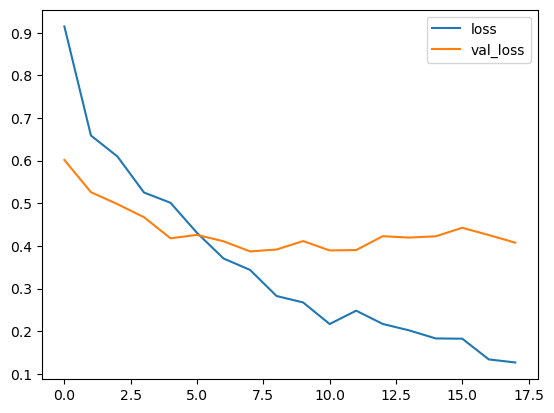

In [311]:
# Evaluating the model performance
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

The trained MNN is used to make predictions of the class labels (i.e. whether a given 2-D Ising state is above or below the Curie temperature) from the test dataset. The predictions is compared with the actual class labels.

The following shows the confusion matrix when comparing the predictions with the actual class labels as well as relevant statistical reports.

In [312]:
# Evaluating the model performance
# Relevant library
from sklearn.metrics import classification_report,confusion_matrix

# Predictions on the test dataset
predictions = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
print(confusion_matrix(y_test,predictions))

# Classification report
print(classification_report(y_test,predictions))

# Support - Total predicted P OR Total predicted N
# Precision - TP/(TP + FP)
# Recall - TP/ (TP + FN)
# f1 score - 2*(Precision*Recall)/(Precision + Recall)

7/7 [==============================] - 0s 1ms/step
[[67  3]
 [35 95]]
              precision    recall  f1-score   support

         0.0       0.66      0.96      0.78        70
         1.0       0.97      0.73      0.83       130

    accuracy                           0.81       200
   macro avg       0.81      0.84      0.81       200
weighted avg       0.86      0.81      0.81       200



From the confusion matrix, we can see that the MNN has achieved an accuracy of $81\%$. 

The MNN seems to perform poorly in predicting 2-D Ising states that are below the Curie temperature. It makes sense since the MNN is trained on a dataset with a larger proportion of 2-D Ising states that are generated at temperatures above the Curie temperature. 

A possible remedy is to consider training datasets of larger sizes (with relatively the same proportional of above-Curie temperature and below-Curie temperature 2-D Ising states). 

We can also consider exploring more classes instead of the current binary class prediction as well as explore tuning the hyperparameters of the MNN to improve its performance.

### Ongoing future works:

1) Testing models with different sets of hyperparameters to find the best hyperparameters for the MNN (e.g. number of activation units in first hidden layer; number of epochs; number of dropout layers etc.)

2) Prediction with a larger training dataset

3) Multi-class classification